# Validation of ESG module

Modelling stocks with GBM and rates with Ornstein–Uhlenbeck SDE <br>
GBM:           $dS(t) = \mu S(t) dt + \sigma S(t) dB(t)$ <br>
O-U (Vasicek): $dr(t) = a(\mu - r(t)) dt + \sigma dB(t)$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from source.noise import NoiseGenerator
from source.esg import EconomicScenarioGenerator

In [2]:
N = 100000
interval = 12
T = 5
steps = interval * T

In [3]:
NG = NoiseGenerator()

Simulation parameters

In [4]:
with open('./data/params.pkl', 'rb') as f:
     s0, Corr, variance, mean, ar = pickle.load(f)

In [5]:
s0

AK_SV            224.480000
AK_WORLD        4041.233665
AK_WORLD_LOC     591.744572
ALTERNATIVA      100.000000
CPI              278.000000
FASTIGHETER      100.400000
KRED_SV          196.460000
RB_UTL           329.810800
RB_SV_1_RATE       0.029400
RB_SV_5            0.039880
RB_SV_15           0.048920
SPREAD             0.003790
Name: 2003-12-31, dtype: float64

In [6]:
mean

AK_SV           0.094287
AK_WORLD        0.083859
AK_WORLD_LOC    0.072420
ALTERNATIVA     0.058007
CPI             0.011874
FASTIGHETER     0.086633
KRED_SV         0.034298
RB_UTL          0.034047
RB_SV_1_RATE   -0.006461
RB_SV_5        -0.003037
RB_SV_15        0.015075
SPREAD          0.004960
dtype: float64

Pick index of a stock and a rate

In [7]:
Si = np.where(s0.index == 'AK_SV')[0][0]
ri = np.where(s0.index == 'RB_SV_1_RATE')[0][0]

In [8]:
S0 = s0.to_numpy()[[Si, ri]]
a = ar.to_numpy()[[Si, ri]]
mu = mean.to_numpy()[[Si, ri]]
sigma = np.sqrt(variance.to_numpy()[[Si, ri]])
corrmatrix = Corr.to_numpy()[np.ix_([Si,ri],[Si,ri])]

In [9]:
dB = NG.brown_steps(corrmatrix, N * steps)

In [10]:
dB.shape

(2, 6000000)

In [11]:
ESG = EconomicScenarioGenerator(S0, a, mu, sigma, dB)

In [12]:
AK, RB = ESG.get_scenarios(N, steps, interval)

# Stock simulation

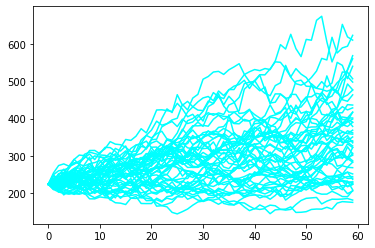

In [13]:
for s in AK[:50]:
    plt.plot(s.T, color='cyan')

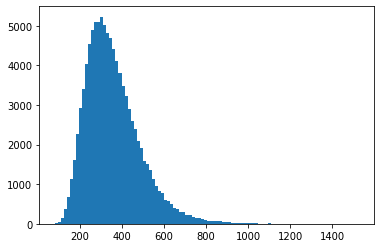

In [14]:
counts, bins = np.histogram(AK[:,:,-1], bins=100)
plt.hist(bins[:-1], bins, weights=counts);

Values in 1% quantiles

In [15]:
[bins[1],bins[99]]

[93.27329697060576, 1512.664125166782]

# Rate simulation

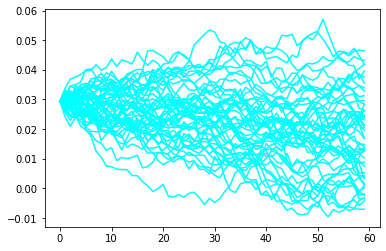

In [16]:
for r in RB[:50]:
    plt.plot(r.T, color='cyan')

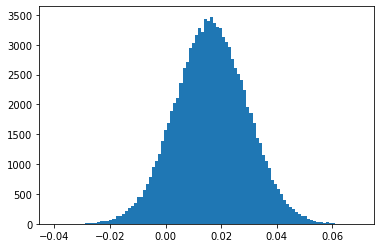

In [17]:
counts, bins = np.histogram(RB[:,:,-1], bins=100)
plt.hist(bins[:-1], bins, weights=counts);

In [18]:
sim_stock_returns = np.diff(np.log(np.squeeze(AK)))
#sim_stock_returns = np.diff(np.squeeze(AK))
sim_rate_returns = np.diff(np.squeeze(RB))

In [19]:
#plt.scatter(sim_stock_returns.flatten(), sim_rate_returns.flatten())

Correlation

In [20]:
np.corrcoef(sim_stock_returns.flatten(), sim_rate_returns.flatten())

array([[1.        , 0.20272646],
       [0.20272646, 1.        ]])

In [21]:
corrmatrix

array([[1.       , 0.2028056],
       [0.2028056, 1.       ]])

Variance

In [22]:
np.cov(sim_stock_returns.flatten(), sim_rate_returns.flatten()) * interval

array([[2.54997504e-02, 2.30854872e-04],
       [2.30854872e-04, 5.08535533e-05]])

In [23]:
sigma**2

array([2.57727660e-02, 5.07720393e-05])

Mean

In [24]:
np.mean(sim_stock_returns.flatten()) * interval, np.mean(sim_rate_returns.flatten()) * interval

(0.0814286333986193, -0.0026490384206382445)

In [25]:
mu

array([ 0.0942865 , -0.00646125])